# TP Integrador Aprendizaje Automático I

### Librerías

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import nbimporter
from funciones import *
from geopy.distance import geodesic

### Carga de datos y exploración

In [72]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

# Lista de ubicaciones permitidas
allowed_locations = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Eliminar las demás ubicaciones del DataFrame original
df = df[df['Location'].isin(allowed_locations)]


In [ ]:
### Vista de datos
df.head()

In [74]:
# Se elimina la primer columna con el índice
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
# Se analizan los tipos de datos que conforman el dataset
print(df.dtypes)

In [76]:
# Se convierte la columna 'Date' de string (object) a datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Se toma como fecha base la mínima fecha del df
fecha_base = df['Date'].min()

# Se calcula el número de días desde la fecha base
df['Date'] = (df['Date'] - fecha_base).dt.days


In [77]:
#Se dummifican las columnas las columnas RainToday y RainTomorrow
#Se eliminan las columnas dummies complementarias para cada variable, a fin de evitar la colinealidad
df = pd.get_dummies(df, columns=['RainToday','RainTomorrow'])
df = df.drop(['RainToday_No','RainTomorrow_No'], axis=1)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow,RainToday_Yes,RainTomorrow_Yes
6047,427,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0.0,False,False
6048,428,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0.0,False,False
6049,429,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,0.0,False,False
6050,430,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0.0,False,False
6051,431,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,3519,MountGambier,6.2,16.3,0.0,NaN,NaN,N,41.0,N,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,2.0,False,True
102516,3520,MountGambier,8.7,13.2,2.0,NaN,NaN,S,20.0,NaN,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,0.0,True,False
102517,3521,MountGambier,7.0,15.7,0.0,NaN,NaN,N,31.0,N,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,0.0,False,False
102518,3522,MountGambier,5.4,16.2,0.0,NaN,NaN,N,37.0,NNW,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,2.2,False,True


In [78]:
df.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,28233.000000,27663.000000,27675.000000,27247.000000,23880.000000,21520.000000,26591.000000,27875.000000,27893.000000,27293.000000,27343.000000,27394.000000,27404.000000,18866.000000,18683.000000,27648.000000,27657.000000,27248.000000
mean,1913.110367,11.263319,21.902078,2.050369,4.826499,6.891129,41.835471,15.130152,20.023052,68.766350,50.497385,1018.249325,1016.149624,4.668557,4.732805,15.477127,20.408345,2.049347
std,948.862211,5.709936,6.693168,6.384560,3.707995,3.867622,14.186300,9.458606,8.979409,18.730306,19.944931,7.423776,7.267376,2.807571,2.628154,5.701031,6.532302,6.383931
min,0.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,5.000000,1.000000,982.300000,984.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,1082.000000,7.400000,16.600000,0.000000,2.200000,3.800000,31.000000,9.000000,13.000000,57.000000,37.000000,1013.300000,1011.300000,1.000000,2.000000,11.400000,15.400000,0.000000
50%,1955.000000,10.900000,21.000000,0.000000,4.000000,7.400000,39.000000,13.000000,19.000000,70.000000,50.000000,1018.400000,1016.300000,6.000000,6.000000,15.000000,19.500000,0.000000
75%,2739.000000,15.200000,26.200000,1.000000,6.600000,10.000000,50.000000,20.000000,26.000000,83.000000,64.000000,1023.300000,1021.100000,7.000000,7.000000,19.125000,24.500000,1.000000
max,3523.000000,33.900000,46.800000,119.400000,86.200000,14.300000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,38.600000,46.100000,119.400000


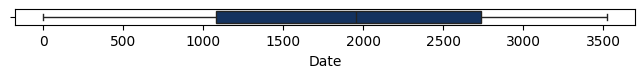

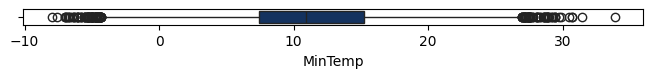

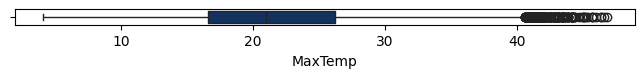

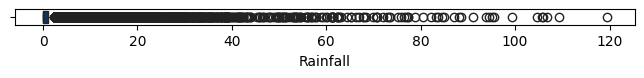

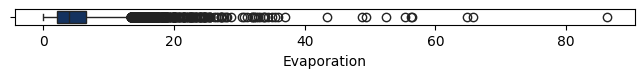

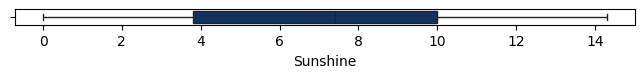

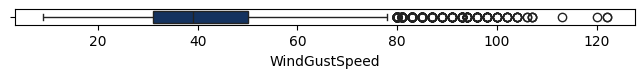

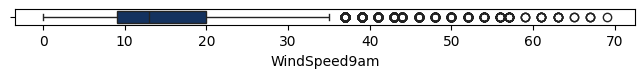

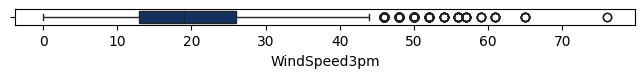

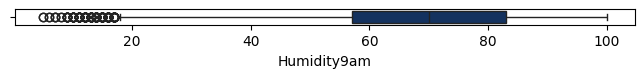

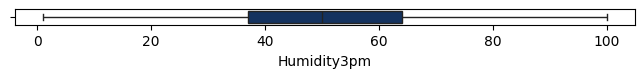

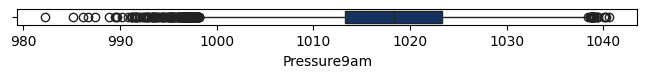

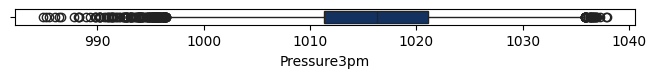

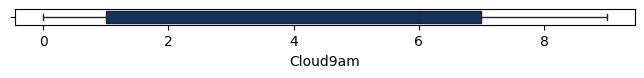

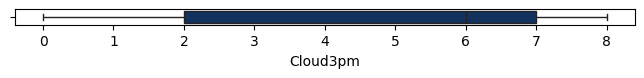

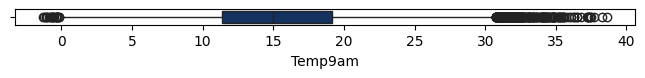

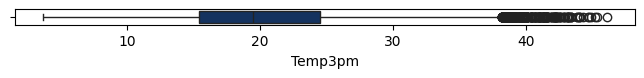

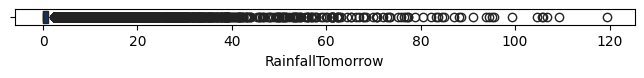

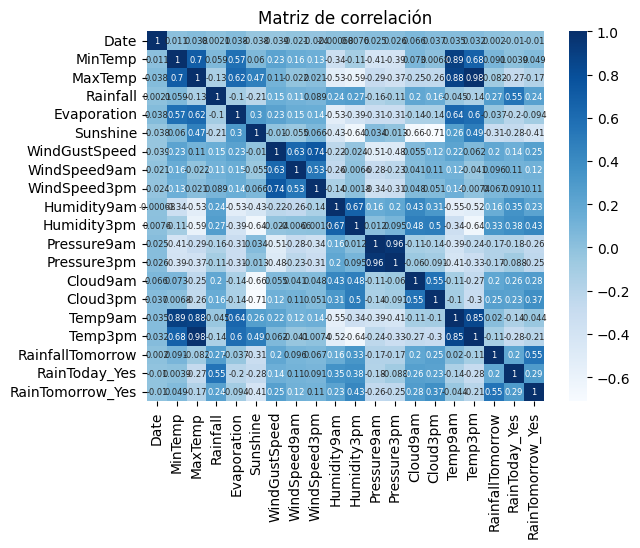

In [93]:
explorar(df)

### Análisis de valores nulos

#### Primeros análisis

Se cuentan los valores nulos por variable, comenzando por aquellas en donde se supera el 5% de la totalidad de los datos.

In [102]:
print(int(0.05 * df.shape[0]))

1411


In [103]:
### Cantidad de valores faltantes.
df.isna().sum().sort_values(ascending=False)

Cloud3pm            9550
Cloud9am            9367
Sunshine            6713
Evaporation         4353
WindDir9am          1648
WindGustDir         1645
WindGustSpeed       1642
Rainfall             986
RainfallTomorrow     985
Humidity9am          940
Humidity3pm          890
Pressure9am          839
Pressure3pm          829
Temp9am              585
Temp3pm              576
MinTemp              570
MaxTemp              558
WindDir3pm           437
WindSpeed9am         358
WindSpeed3pm         340
RainToday_Yes          0
Date                   0
Location               0
RainTomorrow_Yes       0
dtype: int64

Se analiza a continuación cada variable, con su variable más correlacionada, y la cantidad de nulos de cada una:

In [104]:
analisis_nan(df)

g:\Mi unidad\TUIA\IA4.1 AA I\Trabajo Práctico Integrador\AA1-TUIA-Garcia-Herrera\funciones.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Date,Cloud9am,0.066170,0
1,MinTemp,Temp9am,0.893170,570
2,MaxTemp,Temp3pm,0.982436,558
3,Rainfall,RainToday_Yes,0.552161,986
4,Evaporation,Temp9am,0.643411,4353
5,Sunshine,Cloud3pm,-0.710729,6713
6,WindGustSpeed,WindSpeed3pm,0.739562,1642
7,WindSpeed9am,WindGustSpeed,0.631457,358
8,WindSpeed3pm,WindGustSpeed,0.739562,340
9,Humidity9am,Humidity3pm,0.670666,940


Se observa que las variables Cloud9am y Cloud3pm no presentan una fuerte correlación con las demás, al punto de considerar reconstruir los valores nulos mediante regresión lineal.
Es por eso que se hace a continuación un análisis más detallado para estas variables.

#### Análisis nulos para Cloud9am y Cloud3pm

Se construye una matriz con las distancias entre ciudades, que ayudará a comprender la posibilidad de adoptar valores de ciudades aledañas:

In [86]:
# Coordenadas de las ciudades
cities_coords = {
    'Adelaide': (-34.9285, 138.6007),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'Dartmoor': (-37.9225, 141.2760),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'MountGambier': (-37.8284, 140.7804),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753)
}

# Crear un DataFrame vacío
dist_matrix = pd.DataFrame(index=cities_coords.keys(), columns=cities_coords.keys())

# Calcular las distancias y llenar la matriz
for city1 in cities_coords:
    for city2 in cities_coords:
        dist = geodesic(cities_coords[city1], cities_coords[city2]).kilometers
        dist_matrix.at[city1, city2] = round(dist, 2)

# Mostrar la matriz de distancias
print(dist_matrix)


                 Adelaide Canberra   Cobar Dartmoor Melbourne  \
Adelaide              0.0   960.32  773.97   409.76    654.36   
Canberra           960.32      0.0  519.56   761.08    467.02   
Cobar              773.97   519.56     0.0   825.72    705.11   
Dartmoor           409.76   761.08  825.72      0.0    324.63   
Melbourne          654.36   467.02  705.11   324.63       0.0   
MelbourneAirport   637.49   466.79  690.56   315.23     19.32   
MountGambier       376.54   798.82  840.92    44.84    368.24   
Sydney            1164.53   246.85   568.4   1002.5    713.86   
SydneyAirport     1160.17   239.41   569.1   995.89    706.42   

                 MelbourneAirport MountGambier   Sydney SydneyAirport  
Adelaide                   637.49       376.54  1164.53       1160.17  
Canberra                   466.79       798.82   246.85        239.41  
Cobar                      690.56       840.92    568.4         569.1  
Dartmoor                   315.23        44.84   1002.5      

El siguiente df...

In [87]:
# DataFrame para almacenar la ciudad más cercana y la distancia
closest_city_and_distance = pd.DataFrame(index=cities_coords.keys(), columns=['Nearest City', 'Distance (km)'])

# Encontrar la ciudad más cercana y la distancia para cada una
for city in dist_matrix.columns:
    closest_city = dist_matrix[city].drop(city).idxmin()
    closest_distance = dist_matrix.at[city, closest_city]
    closest_city_and_distance.at[city, 'Nearest City'] = closest_city
    closest_city_and_distance.at[city, 'Distance (km)'] = closest_distance

# Contar NaN en 'Cloud9am' y agrupar por ciudad
nan_count_per_city = df[df['Cloud3pm'].isna()]['Location'].value_counts()

# Convertir la serie en un DataFrame
nan_count_df = nan_count_per_city.reset_index()
nan_count_df.columns = ['Location', 'Cloud3pm NaN Count']

# Unir nan_count_df con closest_city_and_distance, manteniendo nan_count_df como el DataFrame principal
complete_info = nan_count_df.merge(closest_city_and_distance, how='left', left_on='Location', right_index=True)

print(complete_info)

           Location  Cloud3pm NaN Count      Nearest City Distance (km)
0          Adelaide                3192      MountGambier        376.54
1          Dartmoor                3008      MountGambier         44.84
2          Canberra                1262     SydneyAirport        239.41
3         Melbourne                1106  MelbourneAirport         19.32
4            Sydney                 563     SydneyAirport          8.49
5             Cobar                 308          Canberra        519.56
6      MountGambier                 110          Dartmoor         44.84
7  MelbourneAirport                   1         Melbourne         19.32


In [81]:
#días que llovió y no hay valores para Cloud9am
count_rows = df[(df['RainToday_Yes'] == True) & (df['Cloud9am'].isna())].shape[0]
print(f"El número de filas donde 'RainToday_Yes' es True y 'Cloud9am' es NaN es: {count_rows}")

El número de filas donde 'RainToday_Yes' es True y 'Cloud9am' es NaN es: 1975


In [82]:
#días que llovió y no hay valores para Cloud3pm
count_rows = df[(df['RainToday_Yes'] == True) & (df['Cloud3pm'].isna())].shape[0]
print(f"El número de filas donde 'RainToday_Yes' es True y 'Cloud3pm' es NaN es: {count_rows}")

El número de filas donde 'RainToday_Yes' es True y 'Cloud3pm' es NaN es: 2012


In [83]:
#días que Cloud9am y Cloud3pm son nan
count_nans = df[df[['Cloud9am', 'Cloud3pm']].isna().all(axis=1)].shape[0]
print(f"El número de filas donde 'Cloud9am' y 'Cloud3pm' son NaN el mismo día es: {count_nans}")

El número de filas donde 'Cloud9am' y 'Cloud3pm' son NaN el mismo día es: 8858


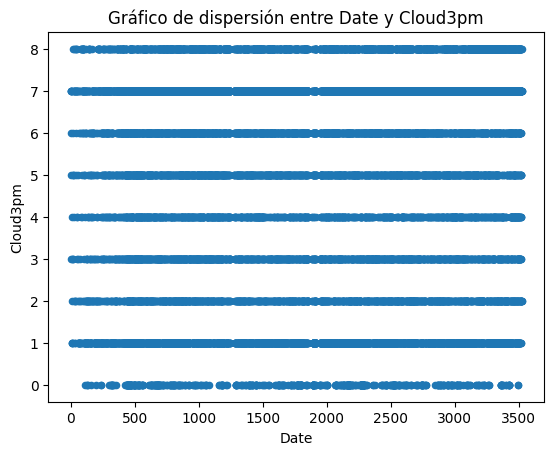

In [84]:
#graf_dispersion(df, df.columns[2], df.columns[2])
graf_dispersion(df, 'Date', 'Cloud3pm')

In [ ]:
#graf_dispersion(df[df['Location'] == 'Adelaide'],'Date','Cloud3pm')
df[df['Location'] == 'Adelaide']

In [92]:
# Filtrar el DataFrame para obtener solo los registros de la ciudad de Adelaide
adelaide_data = df[df['Location'] == 'Dartmoor']

# Contar los valores NaN en la columna 'Cloud3pm'
nan_count = adelaide_data['Cloud3pm'].isna().sum()

# Contar la cantidad total de registros para Adelaide
total_count = adelaide_data.shape[0]

print(f"Cantidad de valores NaN en Cloud3pm para Adelaide: {nan_count}")
print(f"Total de registros para Adelaide: {total_count}")


Cantidad de valores NaN en Cloud3pm para Adelaide: 3008
Total de registros para Adelaide: 3008
